In [274]:
import pandas as pd
import matplotlib.pyplot as plt

In [275]:
df = pd.read_csv(r"D:\Data_Analysis\Projects\Uber\ncr_ride_bookings.csv")

In [276]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Date                               150000 non-null  object 
 1   Time                               150000 non-null  object 
 2   Booking ID                         150000 non-null  object 
 3   Booking Status                     150000 non-null  object 
 4   Customer ID                        150000 non-null  object 
 5   Vehicle Type                       150000 non-null  object 
 6   Pickup Location                    150000 non-null  object 
 7   Drop Location                      150000 non-null  object 
 8   Avg VTAT                           139500 non-null  float64
 9   Avg CTAT                           102000 non-null  float64
 10  Cancelled Rides by Customer        10500 non-null   float64
 11  Reason for cancelling by Customer  1050

## Data Cleaning

In [277]:
# Change Date column to Datetime
df['Date'] = pd.to_datetime(df['Date'], errors = 'coerce')

In [278]:
# Change Time column to datetime.time
df['Time'] = pd.to_datetime(df['Time'],format = '%H:%M:%S', errors = 'coerce').dt.time

In [279]:
# Extract features from date
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.day_name()

In [280]:
# Extract features from time
df['Hour'] = pd.to_datetime(df['Time'], format = '%H:%M:%S', errors = 'coerce').dt.hour

In [281]:
# Handle Categorical NUlls
df['Reason for cancelling by Customer'] = df['Reason for cancelling by Customer'].fillna('Not Applicable')
df['Driver Cancellation Reason'] = df['Driver Cancellation Reason'].fillna('Not Applicable')
df['Incomplete Rides Reason'] = df['Incomplete Rides Reason'].fillna('Not Applicable')
df['Payment Method'] = df['Payment Method'].fillna('Other')

In [282]:
# Handle Numerical Nulls
df['Cancelled Rides by Customer'] = df['Cancelled Rides by Customer'].fillna(0)
df['Cancelled Rides by Driver'] = df['Cancelled Rides by Driver'].fillna(0)
df['Incomplete Rides'] = df['Incomplete Rides'].fillna(0)
df['Booking Value'] = df['Booking Value'].fillna(0)
df['Ride Distance'] = df['Ride Distance'].fillna(0)
df['Driver Ratings'] = df['Driver Ratings'].fillna(0)
df['Customer Rating'] = df['Customer Rating'].fillna(0)
df['Avg VTAT'] = df['Avg VTAT'].fillna(0)
df['Avg CTAT'] = df['Avg CTAT'].fillna(0)

# Analysis

## 1. Ride Volume and Demand Patterns

### 1.1 Peak Demand Hours

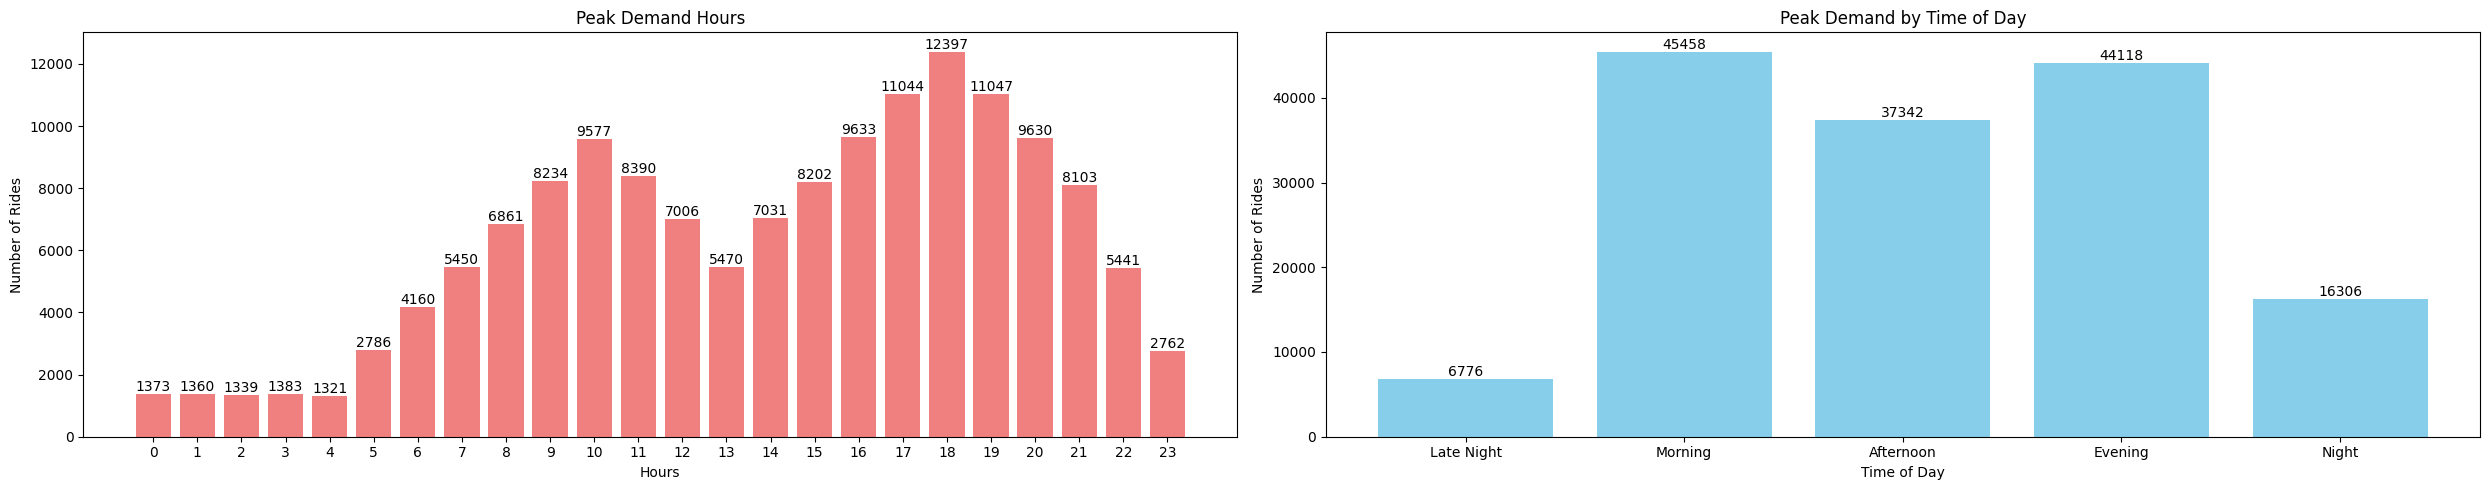

In [283]:
# -- count the number of Rides in each Hour. 
hourly_rides = df.groupby('Hour').size().reset_index(name = 'Number of Rides') 

fig, axes = plt.subplots(1, 2, figsize=(25, 5)) 

bars1 = axes[0].bar(hourly_rides['Hour'], hourly_rides['Number of Rides'], color = 'lightcoral')
axes[0].set_title('Peak Demand Hours')
axes[0].set_xlabel('Hours')
axes[0].set_ylabel('Number of Rides')
axes[0].set_xticks(hourly_rides['Hour'])
axes[0].bar_label(bars1)


def get_time_of_day(hour):
    if 5<= hour < 12:
        return 'Morning'
    elif 12<= hour < 17:
        return 'Afternoon'
    elif 17<= hour < 21:
        return 'Evening'
    elif 21 <= hour <24:
        return 'Night'
    else:
        return 'Late Night'

# Create new column Time_of_day
df['Time_of_day'] = df['Hour'].apply(get_time_of_day)

# Group by the new Column
time_rides = df.groupby('Time_of_day').size().reset_index(name = 'Number of Rides')

# Ensure proper order
order = ['Late Night', 'Morning', 'Afternoon', 'Evening', 'Night']
time_rides['Time_of_day'] = pd.Categorical(time_rides['Time_of_day'], categories=order, ordered=True)
time_rides = time_rides.sort_values('Time_of_day')

bars2 = axes[1].bar(time_rides['Time_of_day'], time_rides['Number of Rides'], color = 'skyblue')
axes[1].set_title('Peak Demand by Time of Day')
axes[1].set_xlabel('Time of Day')
axes[1].set_ylabel('Number of Rides')
axes[1].set_xticks(time_rides['Time_of_day'])
axes[1].bar_label(bars2)

plt.tight_layout()
plt.show()


The highest demand for rides occurs during the Morning - 5-12 AM (45,458 rides) and Evening - 5-9 PM (44,118 rides) periods, which typically correspond to Office commute times. 
Specifically, the hourly data shows a significant surge in rides during the evening peak, with demand highest peaking at 6 PM (hour with 12,393 rides.
This pattern can be leveraged to optimize driver allocation and surge pricing strategies.

### 1.2 Weekday vs Weekend

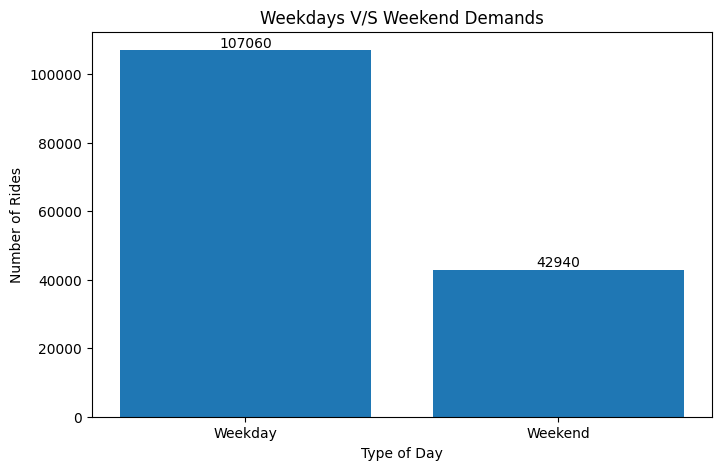

In [284]:
def get_weekend(week_day):
    if week_day == 'Saturday' or week_day == 'Sunday':
        return 'Weekend'
    else:
        return 'Weekday'

df['Type_of_day'] = df['Weekday'].apply(get_weekend)

type_of_day = df.groupby('Type_of_day').size().reset_index(name='Number of Rides')

plt.figure(figsize=(8,5))
bars = plt.bar(type_of_day['Type_of_day'], type_of_day['Number of Rides'])
plt.title("Weekdays V/S Weekend Demands")
plt.xlabel("Type of Day")
plt.ylabel("Number of Rides")
plt.xticks(type_of_day['Type_of_day'])
plt.bar_label(bars)
plt.show()

There is a significantly higher demand for rides on Weekdays (107,060 rides) compared to the Weekend (42,940 rides). This indicates that the majority of ride usage is likely driven by daily commuting or work-related travel rather than leisure or weekend activities.

### 1.3 High Demand Zones - Hotspots

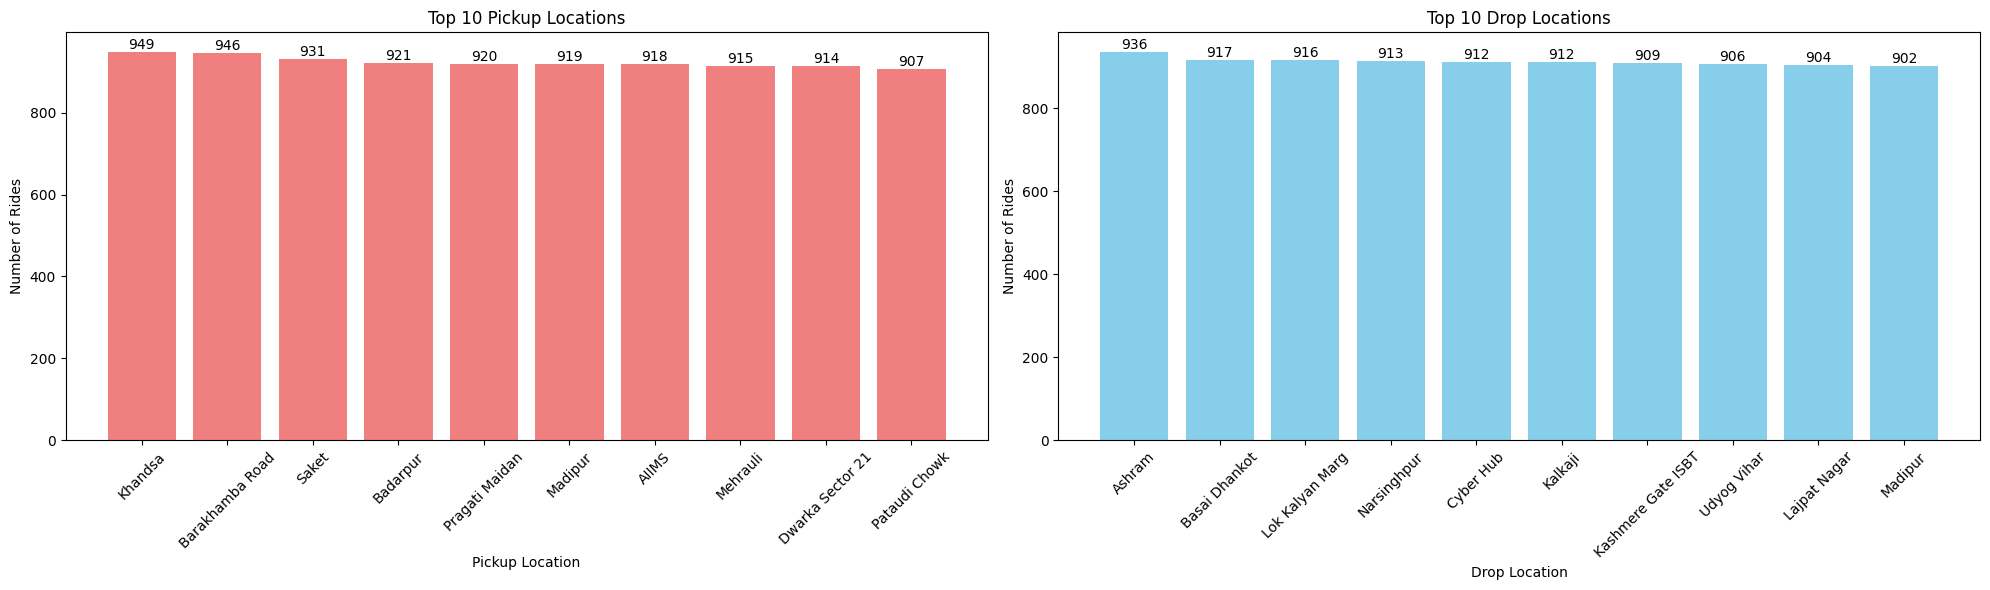

In [285]:
pickup_locations = df.groupby('Pickup Location').size().reset_index(name = 'Number of rides')
pickup_locations = pickup_locations.nlargest(10, 'Number of rides')

drop_locations = df.groupby('Drop Location').size().reset_index(name = 'Number of rides')
drop_locations = drop_locations.nlargest(10, 'Number of rides')

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

bars1 = axes[0].bar(pickup_locations['Pickup Location'], pickup_locations['Number of rides'], color='lightcoral')
axes[0].set_title('Top 10 Pickup Locations')
axes[0].set_xlabel('Pickup Location')
axes[0].set_ylabel('Number of Rides')
axes[0].bar_label(bars1)
axes[0].tick_params(axis='x', rotation=45)  # Rotate labels for readability

bars2 = axes[1].bar(drop_locations['Drop Location'], drop_locations['Number of rides'], color='skyblue')
axes[1].set_title('Top 10 Drop Locations')
axes[1].set_xlabel('Drop Location')
axes[1].set_ylabel('Number of Rides')
axes[1].bar_label(bars2)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# It automatically adjusts spacing between: Subplots (fig, axes = plt.subplots(...)) , Axes titles, Labels, Tick labels
# so that nothing overlaps and everything fits neatly within the figure area.

Khandasa (949 rides) is the busiest pickup zone, while Ashram (936 rides) is the busiest drop-off zone, indicating a high volume of travel activity across these major city areas.

## 2. Ride Status and Cancellation Reasons

### 2.1 Distribution of Ride Booking Status

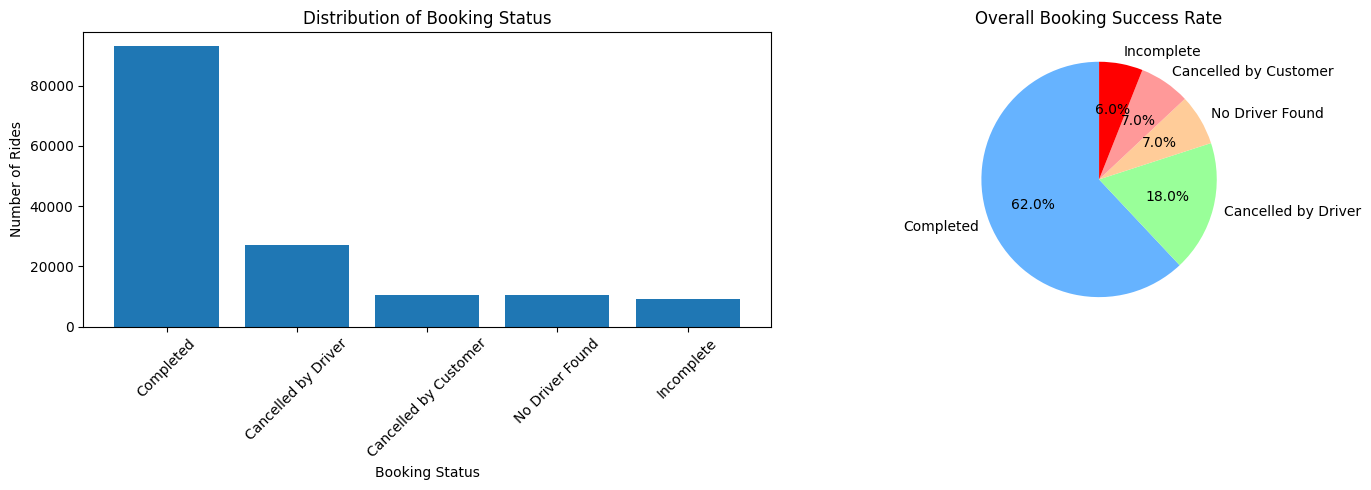

In [286]:
status = df.groupby('Booking Status').size().reset_index(name = 'Number of Rides').sort_values(by = 'Number of Rides', ascending = False)
status

success_rate = df['Booking Status'].value_counts(normalize=True) * 100

fig, axes = plt.subplots(1,2,figsize=(15,5))
bars1 = axes[0].bar(status['Booking Status'], status['Number of Rides'])
axes[0].set_title('Distribution of Booking Status')
axes[0].set_xlabel('Booking Status')
axes[0].set_ylabel('Number of Rides')
axes[0].tick_params(axis='x', rotation=45)

success_rate.plot(
    kind='pie', 
    ax=axes[1], 
    autopct='%1.1f%%', 
    colors=['#66b3ff','#99ff99','#ffcc99','#ff9999', '#ff0000'],
    startangle=90
)

axes[1].set_title('Overall Booking Success Rate')
axes[1].set_ylabel('')

plt.tight_layout()

plt.show()

The vast majority of rides are completed rides. The number of rides cancelled by Driver is significantly higher ( 2.5X ) than the rides cancelled by Customer, Suggesting that driver-side cancellations are the main reason for unfulfilled bookings.

### 2.2 Reason for Cancellations: Main reasons behind lost rides - Pareto Analysis

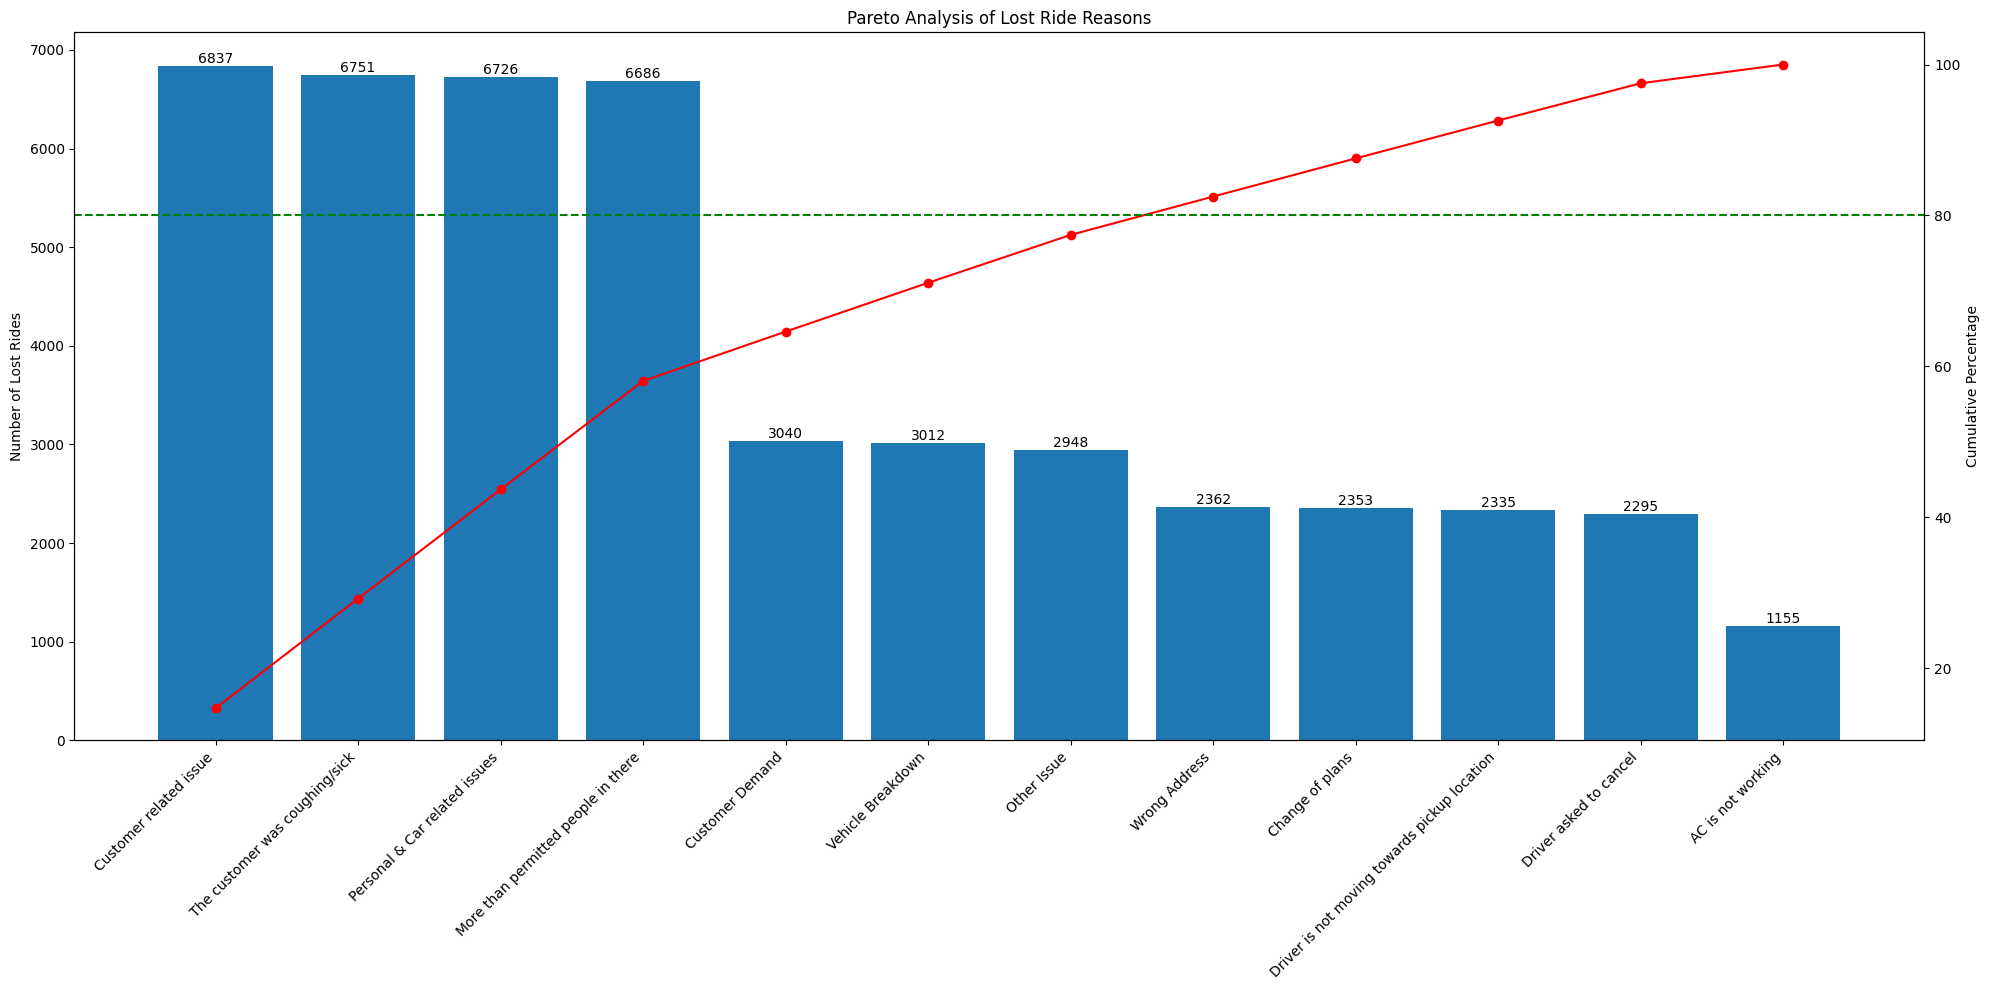

In [287]:
cust_reasons = df.groupby('Reason for cancelling by Customer').size().reset_index(name = 'Total Count').sort_values(by = 'Total Count', ascending=False)
cust_reasons = cust_reasons[cust_reasons['Reason for cancelling by Customer'] != 'Not Applicable']
cust_reasons = cust_reasons.rename(columns={'Reason for cancelling by Customer': 'Reason'})

driver_reasons = df.groupby('Driver Cancellation Reason').size().reset_index(name = 'Total Count').sort_values(by = 'Total Count', ascending=False)
driver_reasons = driver_reasons[driver_reasons['Driver Cancellation Reason'] != 'Not Applicable']
driver_reasons = driver_reasons.rename(columns={'Driver Cancellation Reason': 'Reason'})

incomplete_ride_reason = df.groupby('Incomplete Rides Reason').size().reset_index(name = 'Total Count').sort_values(by = 'Total Count', ascending = False)
incomplete_ride_reason = incomplete_ride_reason[incomplete_ride_reason['Incomplete Rides Reason'] != 'Not Applicable']
incomplete_ride_reason = incomplete_ride_reason.rename(columns={'Incomplete Rides Reason': 'Reason'})

all_lost_rides_reasons = pd.concat([cust_reasons, driver_reasons, incomplete_ride_reason], ignore_index = True)
all_lost_rides_reasons = all_lost_rides_reasons.sort_values(by = 'Total Count', ascending = False)
all_lost_rides_reasons


# Sort values (already done, but keeping it safe)
pareto_df = all_lost_rides_reasons.sort_values(by='Total Count', ascending=False)

# Calculate cumulative percentage
pareto_df['Cumulative %'] = pareto_df['Total Count'].cumsum() / pareto_df['Total Count'].sum() * 100

# Create figure
plt.figure(figsize=(20,10))

# Bar chart (Counts)
bars = plt.bar(pareto_df['Reason'], pareto_df['Total Count'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Lost Rides')
plt.title('Pareto Analysis of Lost Ride Reasons')
plt.bar_label(bars)

# Line chart (Cumulative %)
plt.twinx()
plt.plot(pareto_df['Reason'], pareto_df['Cumulative %'], marker='o', color = 'red')
plt.axhline(80, linestyle='--', color = 'green')  # 80% reference line
plt.ylabel('Cumulative Percentage')

plt.tight_layout()
plt.show()

TThe top four reasons—Customer Issues, Sickness, Personal/Car Issues, and Over-capacity—account for nearly 60% of all lost rides, with the majority being driven by driver-side cancellations rather than customer impatience.

Customer-related issues, health concerns, and personal/car issues are the biggest drivers of ride losses, meaning service quality and customer handling processes are the primary risk areas.

Operational and vehicle issues (breakdowns, AC not working, driver behavior) form the next major layer of losses, indicating fleet quality and driver discipline gaps.


Strategic Action: Since the "Vital Few" reasons are largely health and vehicle-related, implementing stricter vehicle inspections and a driver health-check protocol could prevent over half of the platform's current booking failures.

## 3. Revenue & Business Metrics

### 3.1 Total Booking value Generated

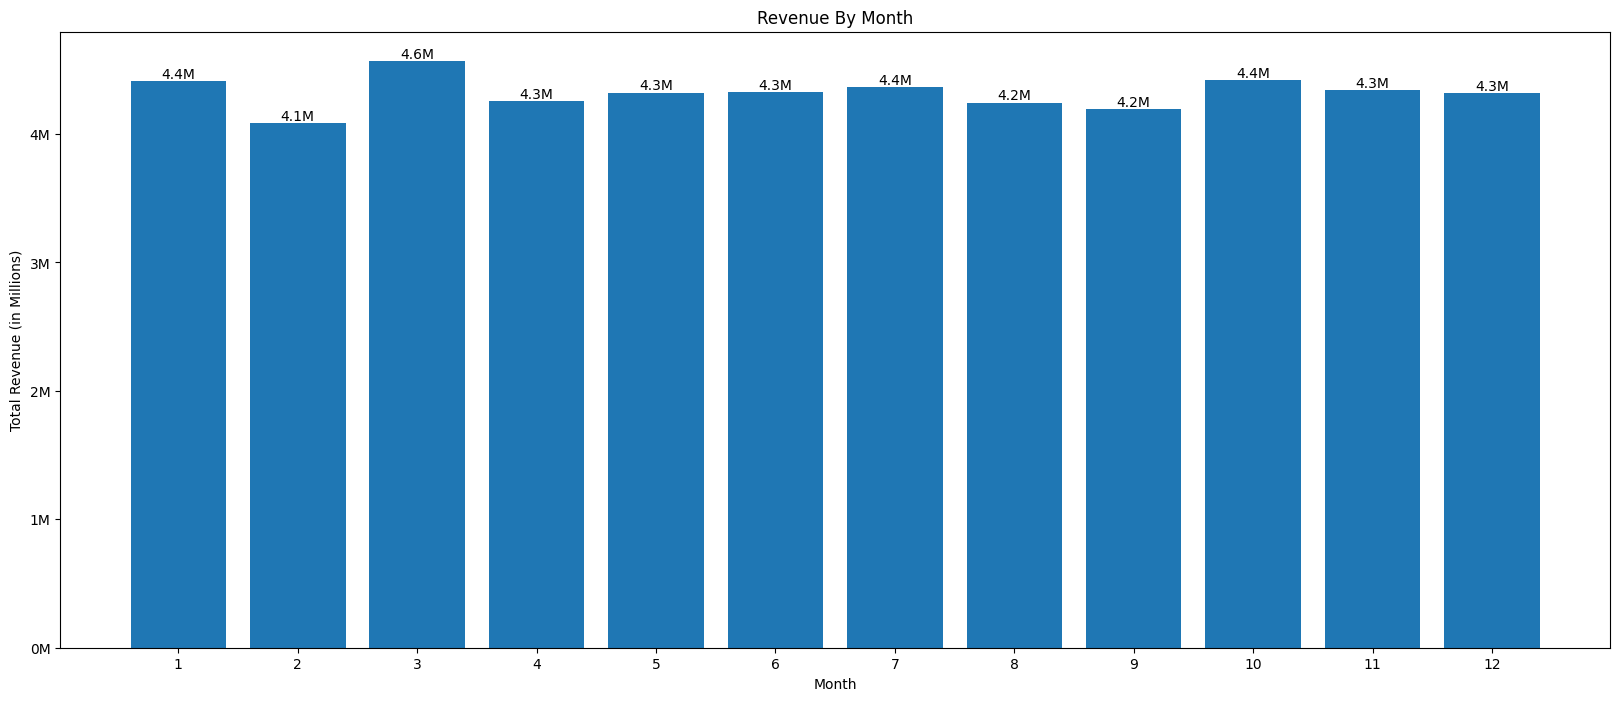

In [288]:
from matplotlib.ticker import FuncFormatter

revenue = df.groupby('Month')['Booking Value'].sum().reset_index(name = 'Total Revenue')

plt.figure(figsize = (20,8))
bars = plt.bar(revenue['Month'], revenue['Total Revenue'])
plt.title('Revenue By Month')
plt.xlabel('Month')
plt.ylabel('Total Revenue (in Millions)')
plt.xticks(revenue['Month'])

# -- Add Bar Labels in Millions 
plt.bar_label(bars, labels = [f"{val/1_000_000:.1f}M" for val in revenue['Total Revenue']])

# Format Y-axis ticks in Millions
formatter = FuncFormatter(lambda x, pos: f'{int(x/1_000_000)}M')
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

Monthly revenue is highly consistent throughout the year, primarily fluctuating between 4.2 Million and 4.4 Million. The peak revenue of 4.6 Million was achieved in March, while February had the lowest revenue at 4.1 Million.

### 3.2 Revenue by Payment Method

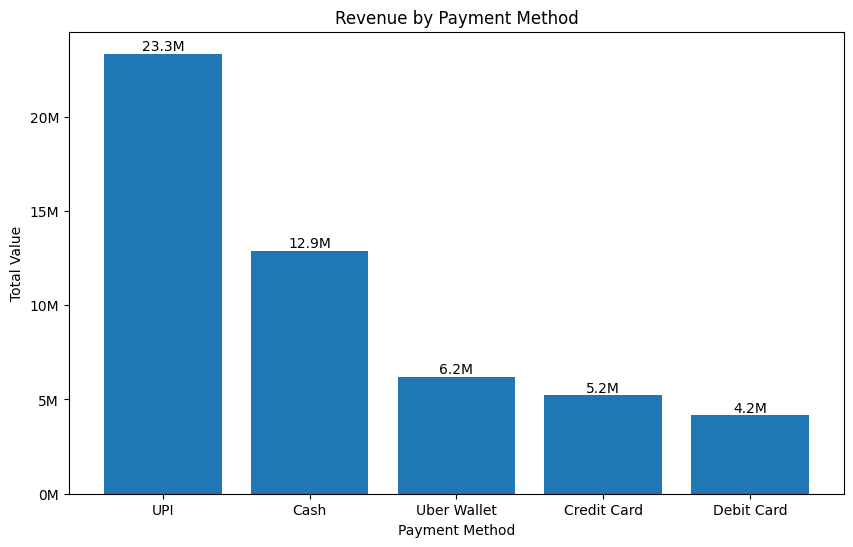

In [289]:
p_rev = df.groupby('Payment Method')['Booking Value'].sum().reset_index(name = 'Total value').sort_values(by = 'Total value', ascending = False)
p_rev = p_rev[p_rev['Payment Method'] != 'Other']

plt.figure(figsize = (10,6))
bars = plt.bar(p_rev['Payment Method'], p_rev['Total value'])
plt.xlabel('Payment Method')
plt.ylabel('Total Value')
plt.title('Revenue by Payment Method')
plt.bar_label(bars, labels = [f"{val/1_000_000:.1f}M" for val in p_rev['Total value']])

# Format Y-axis ticks in Millions
formatter = FuncFormatter(lambda x, pos: f'{int(x/1_000_000)}M')
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

UPI is the dominant payment method, generating the highest revenue at 23.3 Million, significantly more than any other option. Cash is the second most popular method at 12.9 Million, while digital wallet and card payments (Uber Wallet, Credit Card, and Debit Card) contribute the lowest portions of the total revenue.

### 3.3 Revenue by Vehicle Type

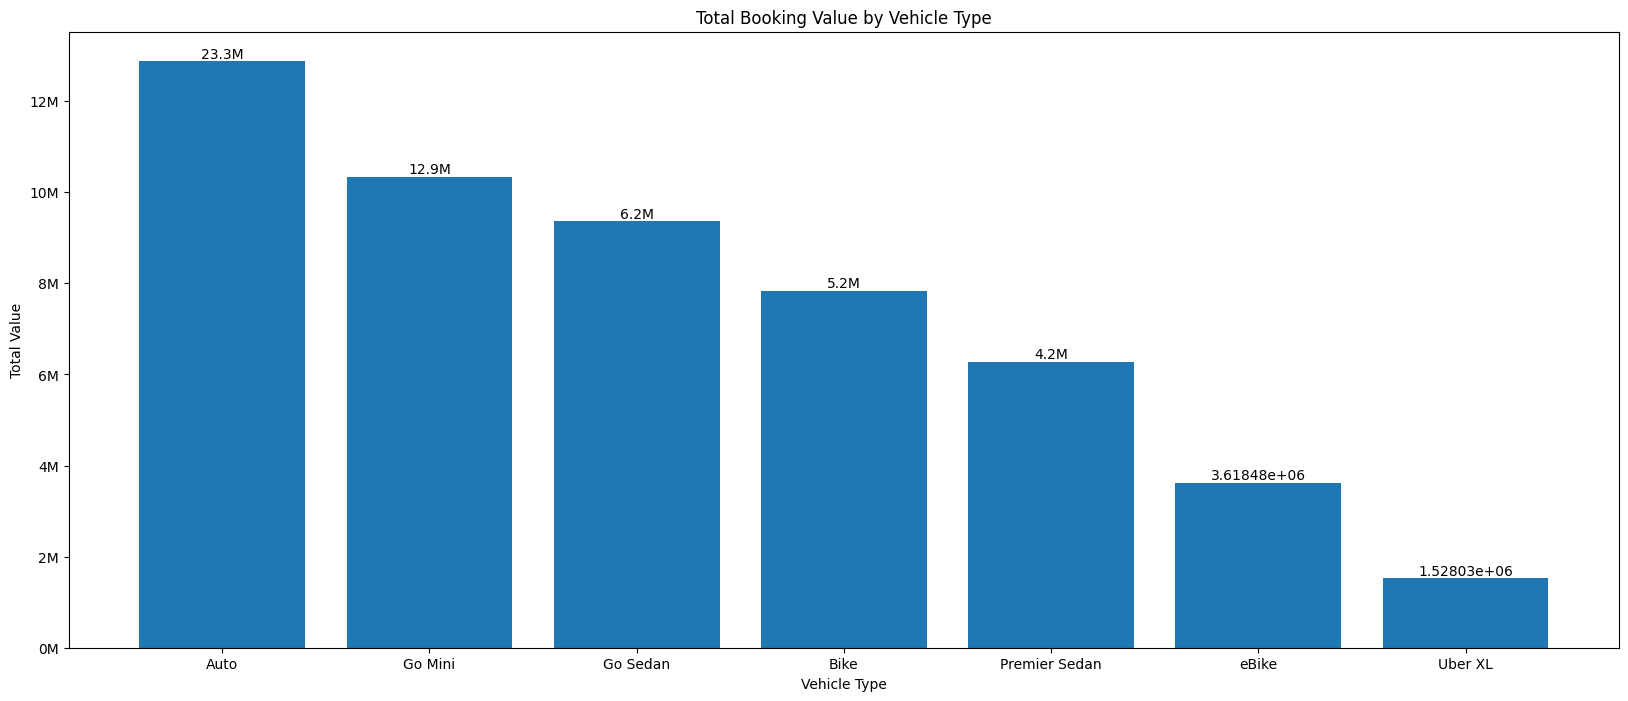

In [290]:
rev_vt = df.groupby('Vehicle Type')['Booking Value'].sum().reset_index(name='Total value').sort_values(by='Total value', ascending = False)

plt.figure(figsize = (20,8))
bars = plt.bar(rev_vt['Vehicle Type'], rev_vt['Total value'])
plt.xlabel('Vehicle Type')
plt.ylabel('Total Value')
plt.title('Total Booking Value by Vehicle Type')
plt.bar_label(bars, labels = [f"{val/1_000_000:.1f}M" for val in p_rev['Total value']])


# Format Y-axis ticks in Millions
formatter = FuncFormatter(lambda x, pos: f'{int(x/1_000_000)}M')
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

Auto rides generate the highest revenue at 12.9 Million, significantly surpassing all other vehicle types. Revenue generally follows a decreasing trend from the smaller/basic car types down to the larger vehicle, with Bike and eBike options contributing mid-to-lower range revenues.

### 3.4 Customer Wait Time (CTAT) Analysis

#### 3.4.1  Wait Time by Vehicle Type

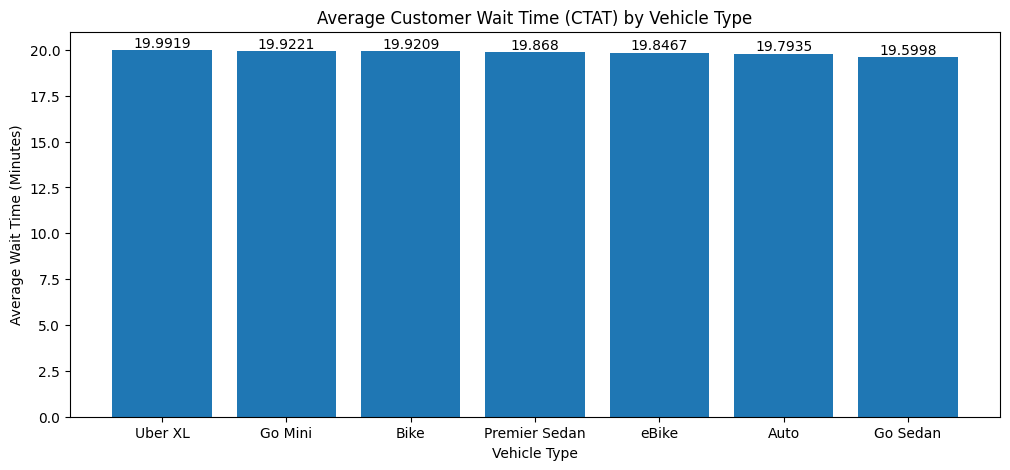

In [291]:
avg_ctat_vehicle = df.groupby('Vehicle Type')['Avg CTAT'].mean().sort_values(ascending = False).reset_index(name = 'Avg CTAT')

plt.figure(figsize=(12, 5))
bars = plt.bar(avg_ctat_vehicle['Vehicle Type'], avg_ctat_vehicle['Avg CTAT'])
plt.title('Average Customer Wait Time (CTAT) by Vehicle Type')
plt.xlabel('Vehicle Type')
plt.ylabel('Average Wait Time (Minutes)')
plt.bar_label(bars)
plt.show()

Average CTAT is almost consistent across all vehicle types, staying close to 20 minutes, indicating standardized response and allocation efficiency. Auto and Go Sedan show slightly lower CTAT, suggesting marginally faster customer-to-arrival times compared to other vehicle categories.

#### 3.4.2 CTAT by Time of the Day

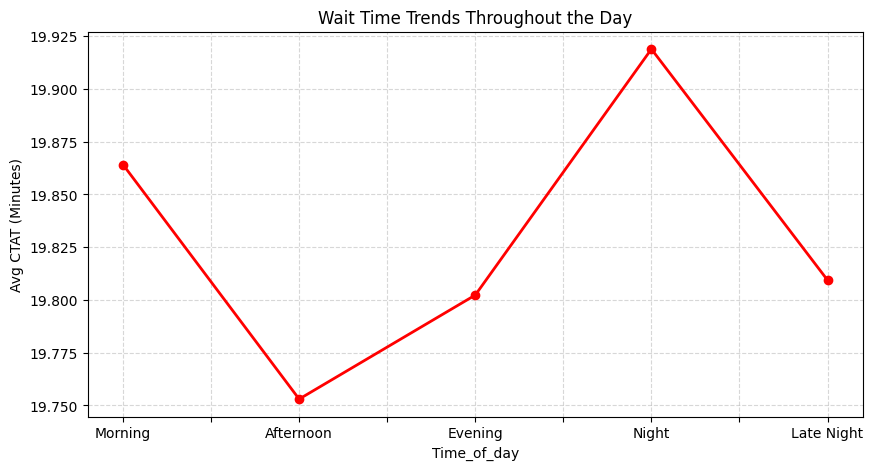

In [314]:
ctat_time = df.groupby('Time_of_day')['Avg CTAT'].mean().reindex(['Morning', 'Afternoon', 'Evening', 'Night', 'Late Night'])

plt.figure(figsize=(10, 5))
ctat_time.plot(kind='line', marker='o', color='red', linewidth=2)
plt.title('Wait Time Trends Throughout the Day')
plt.ylabel('Avg CTAT (Minutes)')
plt.grid(True, linestyle='--', alpha=0.5) # -- Alpha is the visibility of Grid lines (range = 0.0 - 1.0)
plt.show()

Wait times are almost uniform across all time periods, staying very close to ~19.8 minutes, which shows consistent operational performance throughout the day.

Night and Late Night have slightly higher CTAT, indicating minor service delays likely due to reduced driver availability or lower operational staffing.

Overall, there is no major peak-hour stress impact, meaning the system is well-balanced across Morning, Afternoon, Evening, and Night shifts.

#### 3.4.3 High Wait Zones

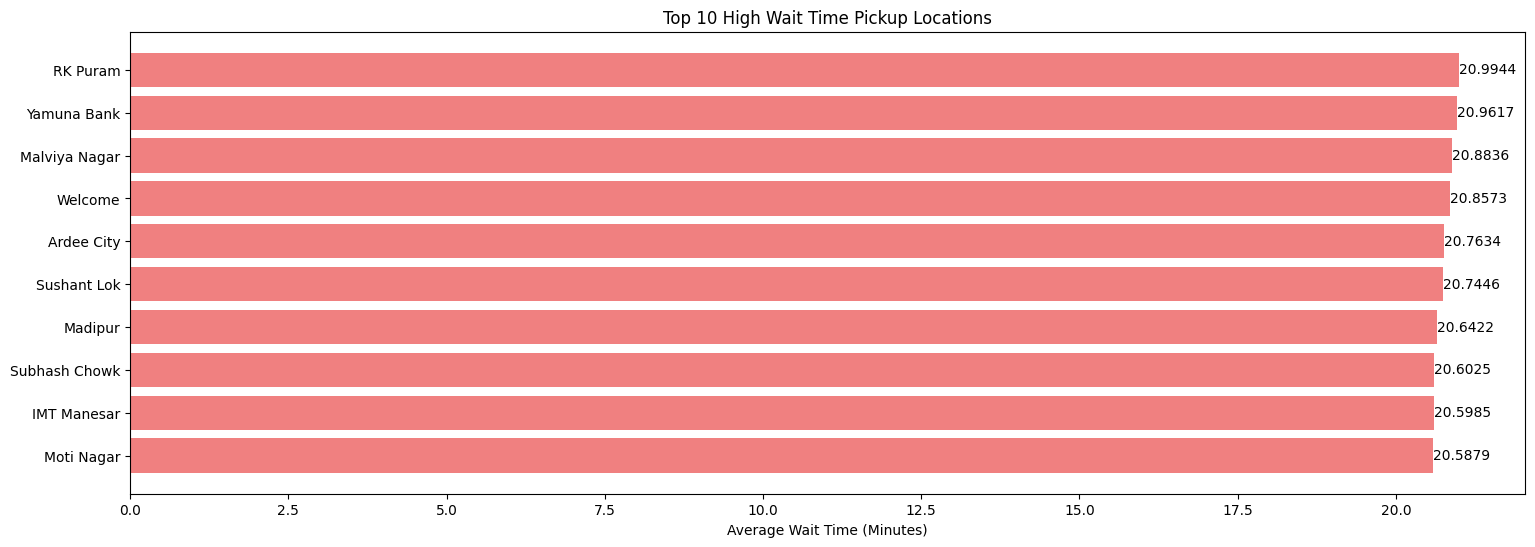

In [293]:
high_wait_zones = df.groupby('Pickup Location')['Avg CTAT'].mean().nlargest(10).reset_index(name = 'Avg CTAT')

plt.figure(figsize = (18,6))
bars = plt.barh(high_wait_zones['Pickup Location'], high_wait_zones['Avg CTAT'], color = 'lightcoral')
plt.gca().invert_yaxis() # Highest wait time on top
plt.title('Top 10 High Wait Time Pickup Locations')
plt.xlabel('Average Wait Time (Minutes)')
plt.bar_label(bars)
plt.show()

These Zones show the highest average wait times, indicating potential demand–supply imbalance or pickup congestion in these areas.
These zones should be priority areas for driver allocation, demand forecasting, and route optimization to reduce customer waiting time.

#### 3.4.4 Wait time vs Cancellations 

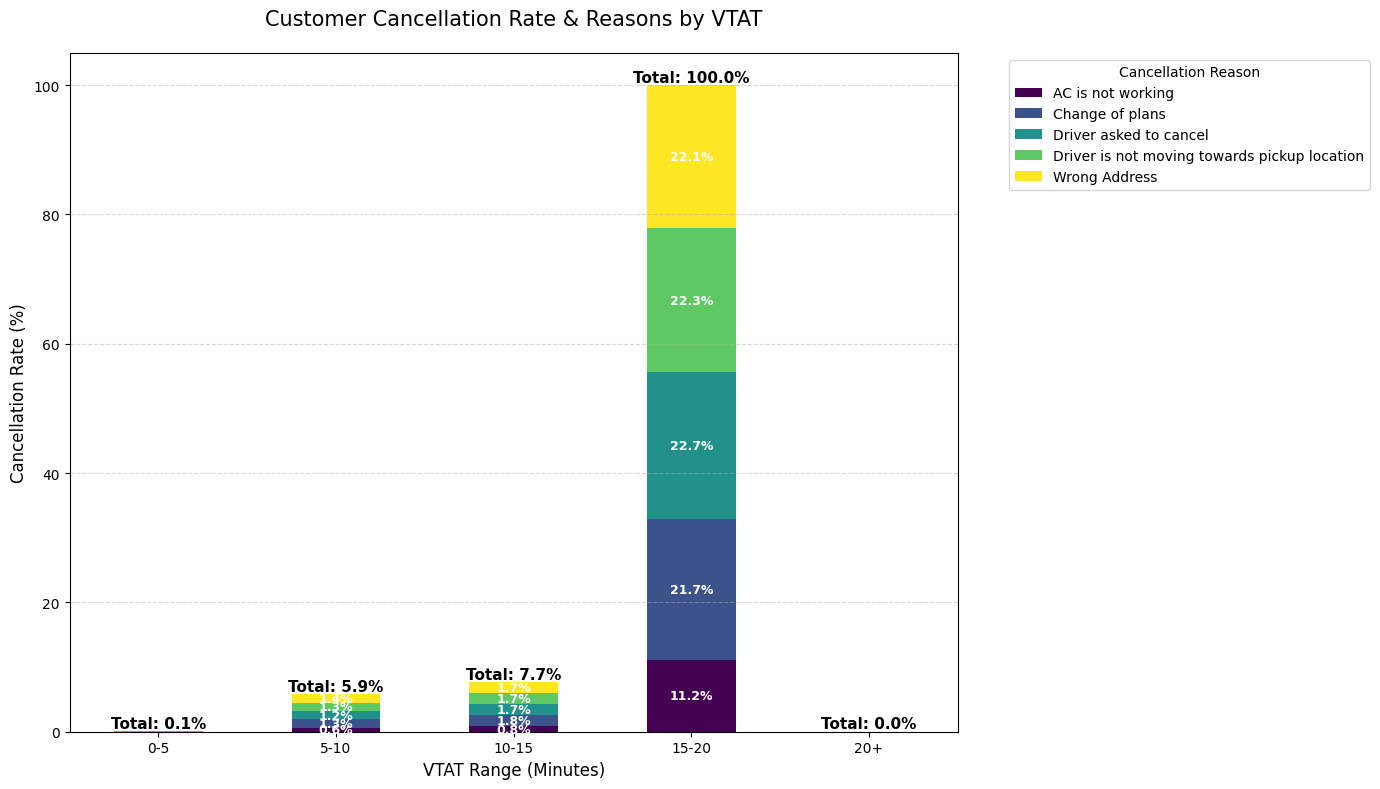

In [321]:
# 1. Create a binary indicator for Customer Cancellation
df['Is_Cancelled_By_Cust'] = df['Booking Status'].apply(lambda x: 1 if x == 'Cancelled by Customer' else 0) 

# 2. Create Bins for VTAT (capturing 0s)
df['VTAT_Bins'] = pd.cut(df['Avg VTAT'], 
                         bins=[0, 5, 10, 15, 20, 40], 
                         labels=['0-5', '5-10', '10-15', '15-20', '20+'],
                         include_lowest=True)

# 3. Calculate Rate per Reason
reason_counts = df.groupby(['VTAT_Bins', 'Reason for cancelling by Customer'], observed=False).size().unstack(fill_value=0)
bin_totals = df.groupby('VTAT_Bins', observed=False).size()

# Convert counts to percentages of total bookings
reason_rates = reason_counts.div(bin_totals, axis=0) * 100

# Remove 'Not Applicable' (rides not cancelled by customer)
if 'Not Applicable' in reason_rates.columns:
    reason_rates = reason_rates.drop(columns=['Not Applicable'])

# 4. Plotting
ax = reason_rates.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='viridis')

# --- EDITED SECTION: LABELING SEGMENTS AND TOTALS ---

# Label each individual segment inside the bar
for c in ax.containers:
    # Use bar_label to add values. 
    # We only show the label if the value is > 0.1 to avoid clutter
    labels = [f'{v.get_height():.1f}%' if v.get_height() > 0.1 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', fontsize=9, color='white', fontweight='bold')

# Add total rate labels on top of the bars
total_rates = reason_rates.sum(axis=1)
for i, total in enumerate(total_rates):
    ax.text(i, total + 0.5, f'Total: {total:.1f}%', ha='center', fontweight='bold', fontsize=11)

# --- FORMATTING ---
plt.title('Customer Cancellation Rate & Reasons by VTAT', fontsize=15, pad=20)
plt.xlabel('VTAT Range (Minutes)', fontsize=12)
plt.ylabel('Cancellation Rate (%)', fontsize=12)
plt.legend(title='Cancellation Reason', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# -- The apply() function in pandas is used for applying a custom function along an axis of a Series or DataFrame
# -- In Python, a lambda function is a small, anonymous function defined using the lambda keyword that can take any number of arguments but can 
#    only have one expression. The result of the single expression is implicitly returned. 
# -- div() is a method used for floating-point division of a DataFrame or Series by another object (scalar, Series, or DataFrame), element-wise
# -- .containers hold all the graphical elements (the bars themselves) of the plot
# -- ax.containers contains each stacked segment in the bar chart
# -- Each c represents one category (e.g., one cancellation reason)


A sharp spike in cancellations occurs in the 15–20 minute range, contributing nearly 100% of total cancellation rate, making it the most critical risk zone.
All major reasons (wrong address, driver not moving, driver asking to cancel, change of plans) peak together in the 15–20 min window, indicating wait time as the primary trigger.

Reducing average wait time to below 10 minutes can significantly cut cancellations, revenue leakage, and customer dissatisfaction.

### 3.5 Revenue Leakage 

#### 3.5.1 Total Potential revenue vs Actual Revenue

Total Potential Revenue: 51,846,183.00
Actual Revenue: 47,260,574.00
Total Revenue Leakage: 4,585,609.00 (8.84%)




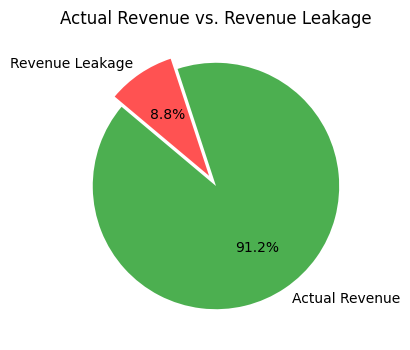

In [295]:
total_potential_revenue = df['Booking Value'].sum()
actual_revenue = df[df['Booking Status'] == 'Completed']['Booking Value'].sum()
revenue_leakage = total_potential_revenue - actual_revenue
leakage_percentage = (revenue_leakage / total_potential_revenue) * 100

print(f"Total Potential Revenue: {total_potential_revenue:,.2f}")
print(f"Actual Revenue: {actual_revenue:,.2f}")
print(f"Total Revenue Leakage: {revenue_leakage:,.2f} ({leakage_percentage:.2f}%)")
print('\n')

plt.figure(figsize = (4,4))
plt.pie([actual_revenue, revenue_leakage],
        labels = ['Actual Revenue', 'Revenue Leakage'],
        autopct = '%1.1f%%',
        colors = ['#4CAF50','#FF5252'],
        explode=[0, 0.1], 
        startangle=140)
plt.title('Actual Revenue vs. Revenue Leakage')
plt.show()

#### 3.5.2 Who is responsible for Leakage

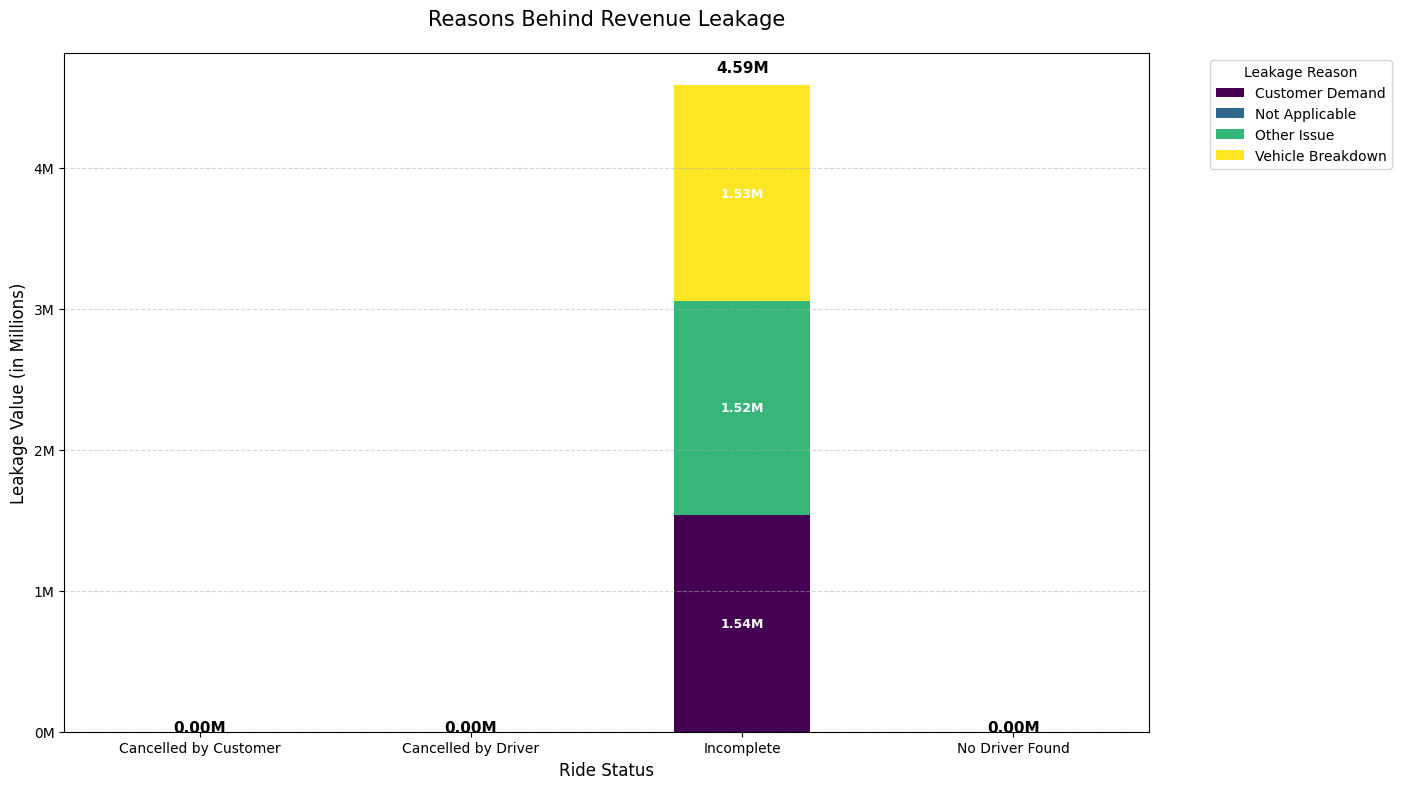

In [296]:
# 3. Group by Booking Status to see leakage breakdown
df_filtered = df[df['Booking Status'] != 'Completed']

status_leakage = df_filtered.groupby('Booking Status')['Booking Value'].sum().reset_index(name = 'Revenue Leakage').sort_values( by = 'Revenue Leakage', ascending=False)

leakage_by_reason = df_filtered.groupby(['Booking Status', 'Incomplete Rides Reason'], observed = False)['Booking Value'].sum().unstack(fill_value = 0)

# Plot
bx = leakage_by_reason.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='viridis')

# Label each individual stacked segment
for c in bx.containers:
    labels = [f"{v.get_height()/1_000_000:.2f}M" if v.get_height() > 0 else "" for v in c]
    bx.bar_label(c, labels=labels, label_type='center', fontsize=9, color='white', fontweight='bold')

# Add total leakage labels on top of each bar
totals = leakage_by_reason.sum(axis=1)

for i, total in enumerate(totals):
    bx.text(i, total + (0.02 * total), f"{total/1_000_000:.2f}M", 
            ha='center', fontsize=11, fontweight='bold')

# --- FORMATTING ---
plt.title('Reasons Behind Revenue Leakage', fontsize=15, pad=20)
plt.xlabel('Ride Status', fontsize=12)
plt.ylabel('Leakage Value (in Millions)', fontsize=12)
plt.legend(title='Leakage Reason', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# Format Y-axis ticks in Millions
formatter = FuncFormatter(lambda x, pos: f'{int(x/1_000_000)}M')
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()


Incomplete rides are the primary source of revenue leakage, accounting for almost the entire lost revenue (~4.59M), while other statuses contribute nearly zero.

Within incomplete rides, leakage is evenly distributed across Customer Demand (Ride Cancelled by Driver), Other Issues, and Vehicle Breakdown, showing system-level operational failures rather than a single cause.

#### 3.6 VTAT by time of the Day 

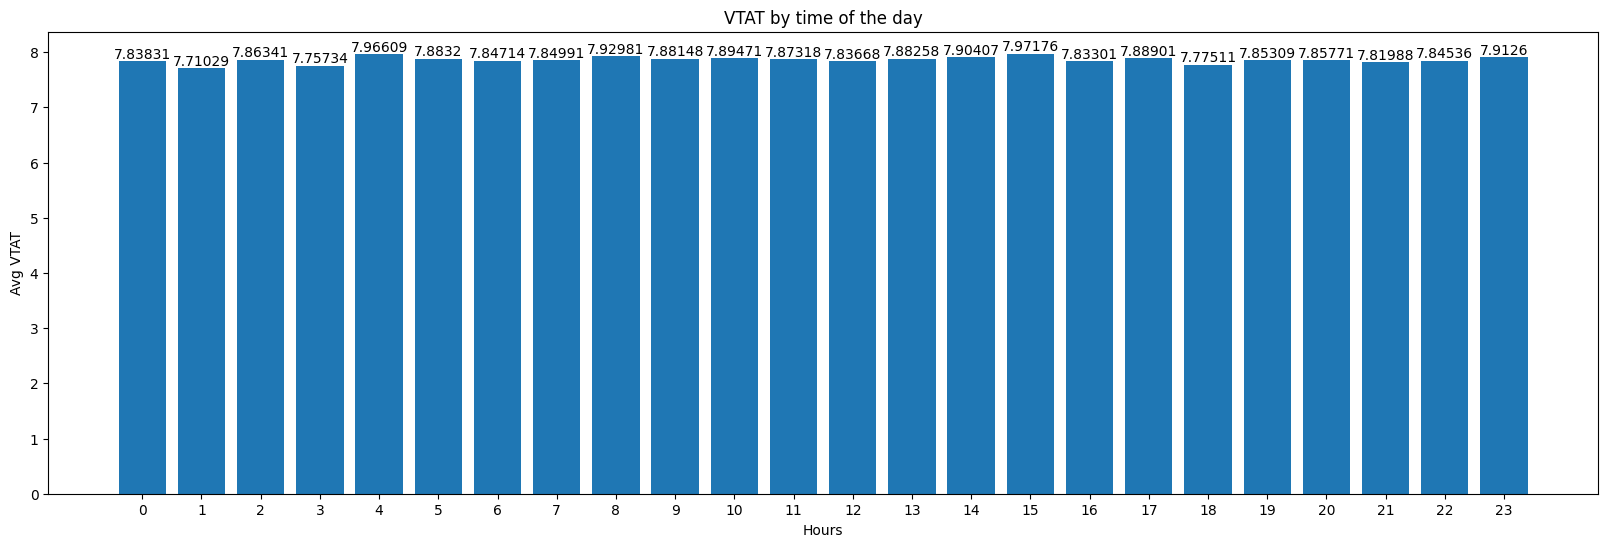

In [297]:
vtat_tod = df.groupby('Hour')['Avg VTAT'].mean().reset_index(name = 'Avg VTAT')

plt.figure(figsize = (20,6))
bar = plt.bar(vtat_tod['Hour'], vtat_tod['Avg VTAT'])
plt.title('VTAT by time of the day')
plt.xlabel('Hours')
plt.ylabel('Avg VTAT')
plt.xticks(hourly_rides['Hour'])
plt.bar_label(bar)
plt.show()

Vehicle Time to Arrival (VTAT) remains highly stable across all hours, staying in a narrow range (~7.7 to ~8.0 minutes), indicating consistent driver availability throughout the day. Peak and late-night hours do not show major spikes

Overall, the platform demonstrates strong operational stability, with no critical hourly bottlenecks in vehicle arrival time.

## 4. Satisfaction Analysis

### Customer and Driver Vehicle rating Distribution

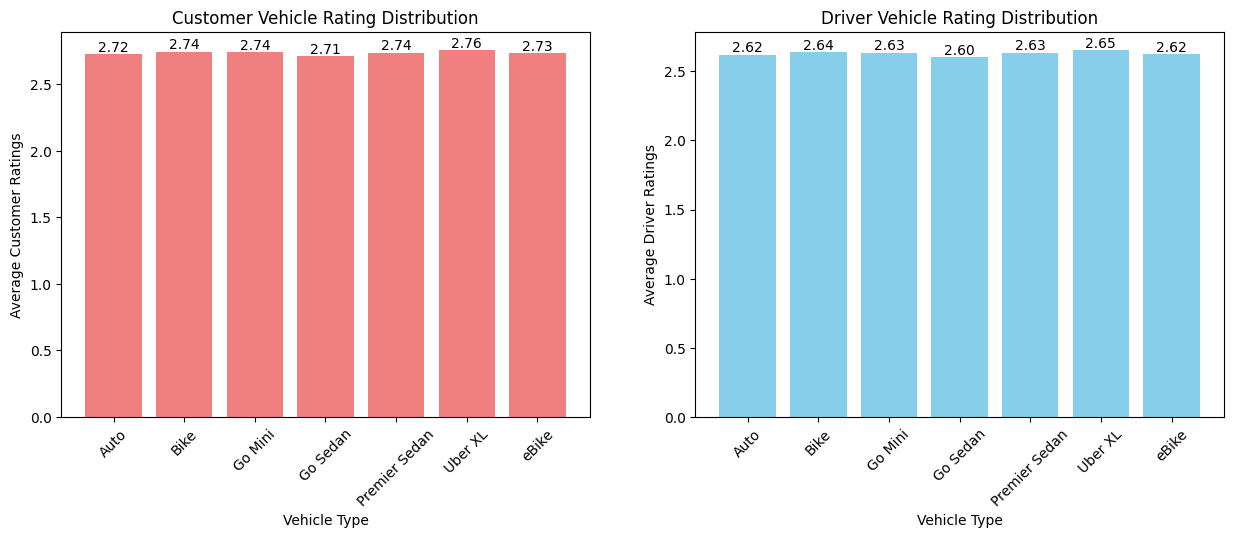

In [298]:
cvrd = df.groupby('Vehicle Type')['Customer Rating'].mean().reset_index(name = 'Avg Ratings')

dvrd = df.groupby('Vehicle Type')['Driver Ratings'].mean().reset_index(name = 'Avg Ratings')

fig, axes = plt.subplots(1,2,figsize=(15,5))
bars1 = axes[0].bar(cvrd['Vehicle Type'], cvrd['Avg Ratings'], color = 'lightcoral')
axes[0].set_title('Customer Vehicle Rating Distribution')
axes[0].set_xlabel('Vehicle Type')
axes[0].set_ylabel('Average Customer Ratings')
axes[0].bar_label(bars1, labels=[f"{val:.2f}" for val in cvrd['Avg Ratings']])
axes[0].tick_params(axis='x', rotation=45)

bars2 = axes[1].bar(dvrd['Vehicle Type'], dvrd['Avg Ratings'], color = 'skyblue'  )
axes[1].set_title('Driver Vehicle Rating Distribution')
axes[1].set_xlabel('Vehicle Type')
axes[1].set_ylabel('Average Driver Ratings')
axes[1].bar_label(bars2, labels=[f"{val:.2f}" for val in dvrd['Avg Ratings']])
axes[1].tick_params(axis='x', rotation=45)

plt.show()

Both customer and driver average vehicle ratings are critically low, consistently falling in the 2.60 to 2.76 range (out of a likely 5-point scale). This indicates a poor quality perception of the vehicles across the entire fleet, affecting both the riders and the drivers.

#### 5. Geographic Route Analysis (The Top Corridors)

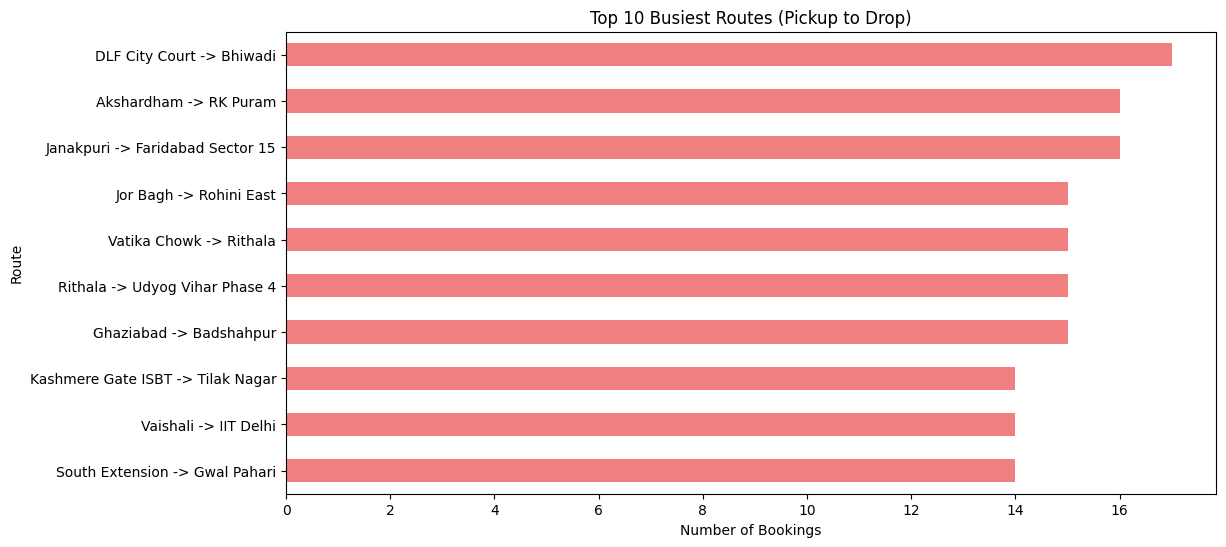

In [323]:
# Create Route Column
df['Route'] = df['Pickup Location'] + " -> " + df['Drop Location']

# Find Top 10 Routes
top_routes = df['Route'].value_counts().nlargest(10)

# Plotting
plt.figure(figsize=(12, 6))
top_routes.plot(kind='barh', color='lightcoral').invert_yaxis()
plt.title('Top 10 Busiest Routes (Pickup to Drop)')
plt.xlabel('Number of Bookings')
plt.show()

A few high-frequency corridors dominate ride demand, with routes like DLF City Court → Bhiwadi and Akshardham → RK Puram emerging as the most active travel paths.

Demand concentration on these corridors suggests opportunities for route-based optimization, such as better driver positioning, surge planning, and faster matching.

Focusing operational resources on these high-traffic routes can reduce wait times, improve completion rates, and increase overall platform efficiency.

#### 6. Temporal Efficiency (Rush Hour Stress Test)

C:\Users\User\AppData\Local\Temp\ipykernel_16312\1633900664.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hourly_stats = df.groupby('Hour').apply(lambda x: (x['Booking Status'] == 'Completed').mean() * 100)


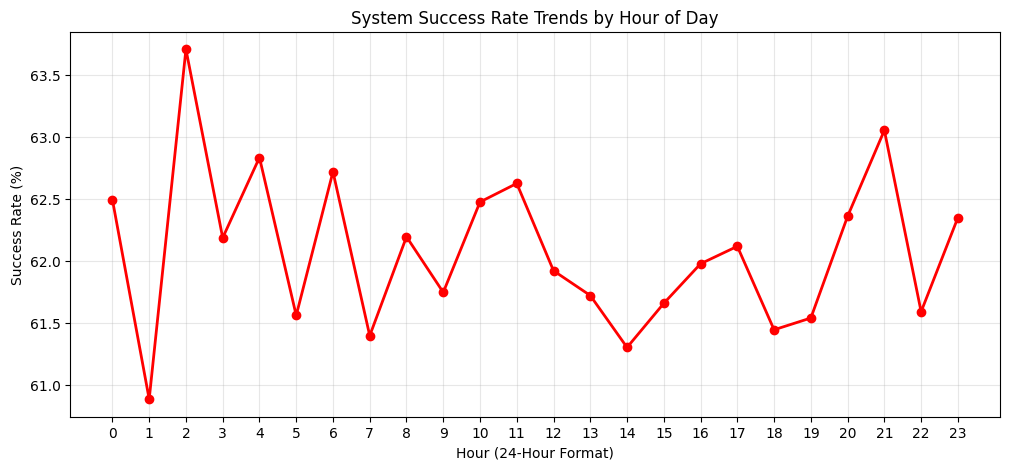

In [303]:
# Extract Hour and Calculate Success Rate
hourly_stats = df.groupby('Hour').apply(lambda x: (x['Booking Status'] == 'Completed').mean() * 100)

# Plotting
plt.figure(figsize=(12, 5))
hourly_stats.plot(kind='line', marker='o', color='red', linewidth=2)
plt.title('System Success Rate Trends by Hour of Day')
plt.ylabel('Success Rate (%)')
plt.xlabel('Hour (24-Hour Format)')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.show()

The platform maintains a highly stable success rate of approximately 62% throughout the day, showing no significant dips even during traditional peak traffic hours (8–10 AM or 5–7 PM).

Strategic Action: Since success never exceeds 64%, the platform likely has a permanent driver shortage that requires long-term fleet expansion rather than just hourly incentives.